# Hudson Valley Gentrification and Changes in Farming

## Notebook 2: ACS and Agriculture Census

In [30]:
import geopandas as gpd
import pandas as pd
import contextily as cx
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shapely
import numpy as np
from censusdis import data as ced
from censusdis.datasets import ACS5
from census import Census

In [2]:
api_key_stadia = os.getenv("STADIA_API_KEY")
api_key_census = os.getenv("CENSUS_API_KEY")
api_key_nass = os.getenv("QUICK_STATS_API_KEY")

In [3]:
proj_nys_east = 26918
proj_hudson_ft = 32118
proj_nyc_ft = 2263
proj_ea = 6933
proj_latlon = 4326

In [4]:
def meters_to_miles(meters):
    return meters/1609
def miles_to_meters(miles):
    return miles*1609

## Import farms and tracts

In [5]:
gdf_farms_all = gpd.read_file("data/farms_core.geojson")

In [6]:
gdf_nys_tracts_2022 = gpd.read_file("data/tl_2022_36_tract.zip") # https://www2.census.gov/geo/tiger/TIGER2022/TRACT/tl_2022_36_tract.zip
gdf_nys_tracts_2017 = gpd.read_file("data/tl_2017_36_tract.zip") # https://www2.census.gov/geo/tiger/TIGER2017/TRACT/tl_2017_36_tract.zip

In [7]:
gdf_nys_counties = gpd.read_file("data/NYS_Civil_Boundaries_2455759864913236436.geojson")

In [8]:
gdf_farms = gdf_farms_all.query("moran == True").copy()

## Select tracts of interest

In [9]:
gdf_farms = gdf_farms.to_crs(proj_nys_east)

In [10]:
gdf_nys_tracts_2022 = gdf_nys_tracts_2022.to_crs(proj_nys_east)
gdf_nys_tracts_2017 = gdf_nys_tracts_2017.to_crs(proj_nys_east)

In [11]:
gdf_nys_counties = gdf_nys_counties.to_crs(proj_nys_east)

In [12]:
gdf_farms["buffer_10mi"] = gdf_farms.buffer(miles_to_meters(10)).geometry

<Axes: >

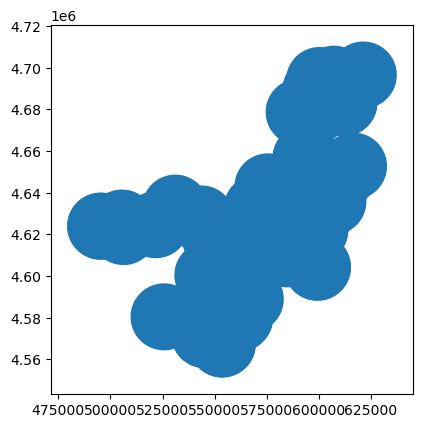

In [13]:
gdf_farms["buffer_10mi"].plot()

<Axes: >

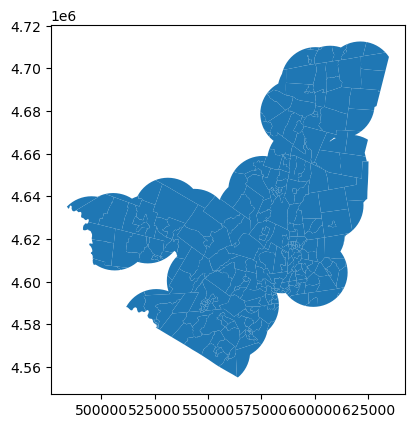

In [14]:
gdf_nys_tracts_2022.clip(gdf_farms["buffer_10mi"]).plot()

<Axes: >

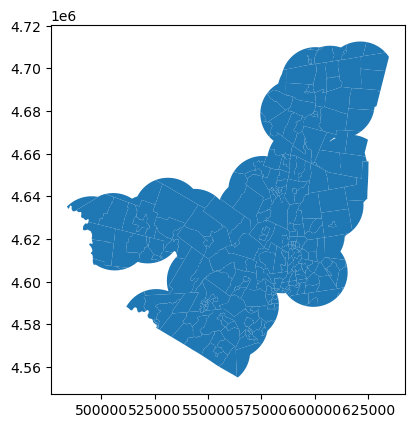

In [15]:
gdf_nys_tracts_2017.clip(gdf_farms["buffer_10mi"]).plot()

In [16]:
gdf_tracts_core_2022 = gdf_nys_tracts_2022[gdf_nys_tracts_2022.index.isin(gdf_nys_tracts_2022.sjoin(gdf_nys_tracts_2022.clip(gdf_farms["buffer_10mi"]), how="inner", predicate="intersects").index)].copy()

In [17]:
gdf_tracts_core_2017 = gdf_nys_tracts_2017[gdf_nys_tracts_2017.index.isin(gdf_nys_tracts_2017.sjoin(gdf_nys_tracts_2017.clip(gdf_farms["buffer_10mi"]), how="inner", predicate="intersects").index)].copy()

<Axes: >

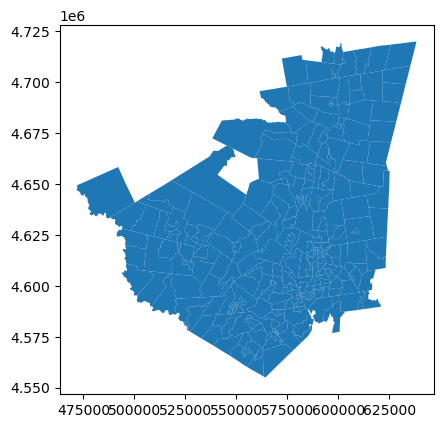

In [18]:
gdf_tracts_core_2022.plot()

<Axes: >

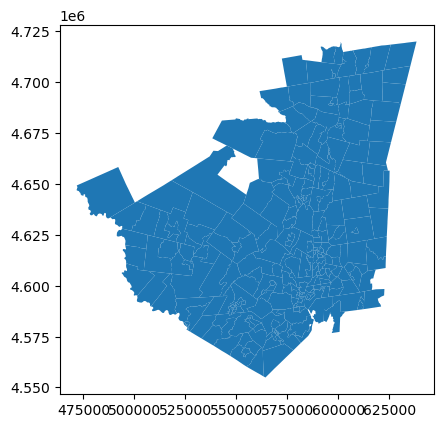

In [19]:
gdf_tracts_core_2017.plot()

In [20]:
gdf_tracts_core_2022.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
104,36,105,951701,36105951701,9517.01,Census Tract 9517.01,G5020,S,80751463,4230629,+41.6252683,-074.6109770,"POLYGON ((527485.433 4611964.593, 527486.865 4..."
105,36,105,951801,36105951801,9518.01,Census Tract 9518.01,G5020,S,9416768,161484,+41.6353707,-074.6665861,"POLYGON ((524469.064 4612440.958, 524508.046 4..."
106,36,105,951302,36105951302,9513.02,Census Tract 9513.02,G5020,S,79633377,998387,+41.6346723,-074.4914470,"POLYGON ((536422.502 4606104.963, 536528.422 4..."
107,36,105,951802,36105951802,9518.02,Census Tract 9518.02,G5020,S,3677536,74552,+41.6500499,-074.7108274,"POLYGON ((523228.27 4610556.874, 523249.305 46..."
108,36,105,950801,36105950801,9508.01,Census Tract 9508.01,G5020,S,35408221,1338257,+41.7864811,-074.6607209,"POLYGON ((524576.278 4626499.536, 524679.494 4..."


In [21]:
gdf_tracts_core_2017 = gdf_tracts_core_2017.assign(COUNTYFIPS = lambda df: df.STATEFP + df.COUNTYFP)

In [22]:
gdf_tracts_core_2022 = gdf_tracts_core_2022.assign(COUNTYFIPS = lambda df: df.STATEFP + df.COUNTYFP)
gdf_tracts_core_2022.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,COUNTYFIPS
104,36,105,951701,36105951701,9517.01,Census Tract 9517.01,G5020,S,80751463,4230629,+41.6252683,-074.6109770,"POLYGON ((527485.433 4611964.593, 527486.865 4...",36105
105,36,105,951801,36105951801,9518.01,Census Tract 9518.01,G5020,S,9416768,161484,+41.6353707,-074.6665861,"POLYGON ((524469.064 4612440.958, 524508.046 4...",36105
106,36,105,951302,36105951302,9513.02,Census Tract 9513.02,G5020,S,79633377,998387,+41.6346723,-074.4914470,"POLYGON ((536422.502 4606104.963, 536528.422 4...",36105
107,36,105,951802,36105951802,9518.02,Census Tract 9518.02,G5020,S,3677536,74552,+41.6500499,-074.7108274,"POLYGON ((523228.27 4610556.874, 523249.305 46...",36105
108,36,105,950801,36105950801,9508.01,Census Tract 9508.01,G5020,S,35408221,1338257,+41.7864811,-074.6607209,"POLYGON ((524576.278 4626499.536, 524679.494 4...",36105


In [23]:
gdf_counties_core = gdf_nys_counties.query("FIPS_CODE in @gdf_tracts_core_2022.COUNTYFIPS").copy()
gdf_counties_core

,OBJECTID,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,geometry
0,1,Albany,ALBA,974099,36001,010000,East,292594,294565,304204,314848,None,None,N,532.791779,"Fri, 10 Nov 2017 00:00:00 GMT","POLYGON ((608218.927 4737613.315, 608193.336 4..."
10,11,Columbia,COLU,974109,36021,100000,East,62982,63094,63096,61570,None,None,N,647.905835,"Mon, 22 Jan 2018 00:00:00 GMT","POLYGON ((624387.318 4656389.284, 624387.085 4..."
12,13,Delaware,DELA,974111,36025,120000,East,47225,48055,47980,44308,None,None,N,1466.338072,"Tue, 19 May 2020 00:00:00 GMT","POLYGON ((523750.277 4707243.712, 523816.31 47..."
13,14,Dutchess,DUTC,974112,36027,130000,East,259462,280150,297488,295911,None,None,N,824.438109,"Thu, 08 Nov 2018 00:00:00 GMT","POLYGON ((624387.318 4656389.284, 624388.346 4..."
19,20,Greene,GREE,974118,36039,190000,East,44739,48195,49221,47931,None,None,N,657.720079,"Tue, 19 May 2020 00:00:00 GMT","POLYGON ((590039.896 4664494.401, 589739.777 4..."
35,36,Orange,ORAN,974134,36071,330000,East,307647,341367,372813,401310,None,None,N,837.148961,"Fri, 15 May 2020 00:00:00 GMT","POLYGON ((587211.589 4604774.186, 587211.21 46..."
39,40,Putnam,PUTN,974138,36079,370000,East,83941,95745,99710,97668,None,None,N,245.989024,"Thu, 08 Nov 2018 00:00:00 GMT","POLYGON ((622581.399 4598234.108, 622573.885 4..."
41,42,Rensselaer,RENS,974140,36083,380000,East,154429,152538,159429,161130,None,None,N,665.084035,"Fri, 10 Nov 2017 00:00:00 GMT","POLYGON ((640790.386 4756004.259, 640790.377 4..."
52,53,Sullivan,SULL,974150,36105,480000,East,69277,73966,77547,78624,None,None,N,995.439165,"Fri, 15 May 2020 00:00:00 GMT","POLYGON ((552753.314 4604558.944, 552710.697 4..."
55,56,Ulster,ULST,974153,36111,510000,East,165304,177749,182493,181851,None,None,N,1161.254720,"Wed, 25 Oct 2017 00:00:00 GMT","POLYGON ((590039.896 4664494.401, 589947.276 4..."


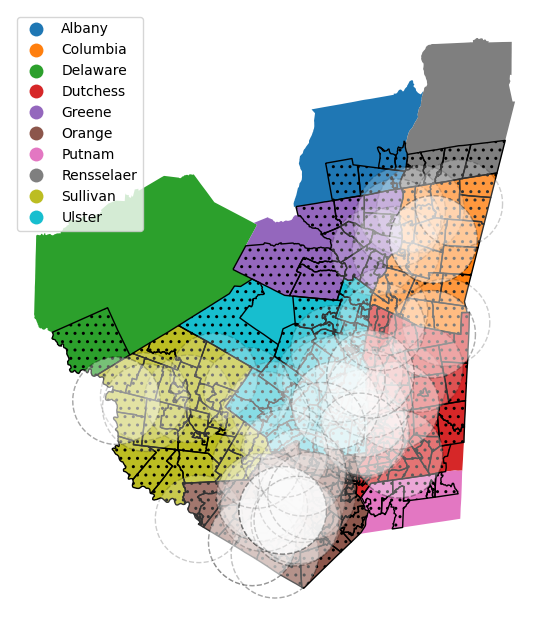

In [24]:
ax = gdf_counties_core.plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2022.plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
gdf_farms["buffer_10mi"].plot(ax=ax, facecolor="white", alpha=0.2, edgecolor="black", linestyle="--")
ax.axis("off");

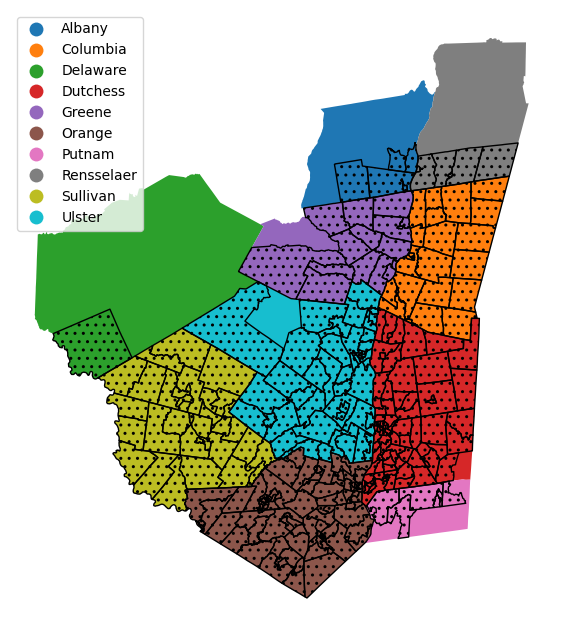

In [25]:
ax = gdf_counties_core.to_crs(proj_hudson_ft).plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2022.to_crs(proj_hudson_ft).plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
ax.axis("off");

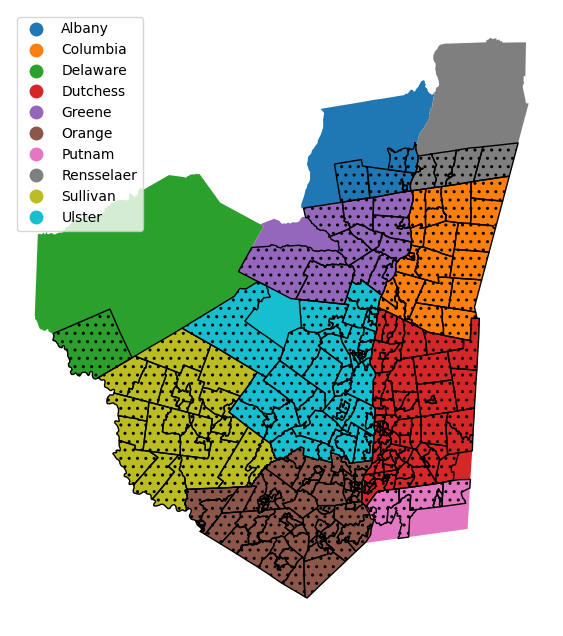

In [26]:
ax = gdf_counties_core.to_crs(proj_hudson_ft).plot(column="NAME", figsize=(8,8), legend=True, legend_kwds={"loc": "upper left"})
gdf_tracts_core_2017.to_crs(proj_hudson_ft).plot(ax=ax, facecolor="none", edgecolor="black", hatch="..")
ax.axis("off");

## Get ACS data

In [27]:
acs_years = ["2017", "2022"]

In [ ]:
acs_var_groups = ["B25003","B25038","B25039",'B25057','B25058','B25059','B25071','B19013','B01003']

In [31]:
c = Census(api_key_census)

In [32]:
acs5tables = pd.DataFrame.from_dict(c.acs5.tables())
acs5tables

,name,description,variables,universe
0,B18104,Sex by Age by Cognitive Difficulty,http://api.census.gov/data/2023/acs/acs5/group...,Civilian noninstitutionalized population 5 yea...
1,B17015,Poverty Status in the Past 12 Months of Famili...,http://api.census.gov/data/2023/acs/acs5/group...,Families
2,B18105,Sex by Age by Ambulatory Difficulty,http://api.census.gov/data/2023/acs/acs5/group...,Civilian noninstitutionalized population 5 yea...
3,B17016,Poverty Status in the Past 12 Months of Famili...,http://api.census.gov/data/2023/acs/acs5/group...,Families
4,B18106,Sex by Age by Self-Care Difficulty,http://api.census.gov/data/2023/acs/acs5/group...,Civilian noninstitutionalized population 5 yea...
...,...,...,...,...
1188,B99131,Allocation of Marital Status for Females 15 to...,http://api.census.gov/data/2023/acs/acs5/group...,Women 15 to 50 years
1189,B09018,Relationship to Householder for Children Under...,http://api.census.gov/data/2023/acs/acs5/group...,Population under 18 years in households (exclu...
1190,B99132,Allocation of Fertility of Women 15 to 50 Years,http://api.census.gov/data/2023/acs/acs5/group...,Women 15 to 50 years
1191,B09019,Household Type (Including Living Alone) by Rel...,http://api.census.gov/data/2023/acs/acs5/group...,Total population


In [37]:
acs5tables = acs5tables.rename(columns={"universe ": "universe"})

In [41]:
acs5vars = acs5tables.query("name in @acs_var_groups")
acs5vars

,name,description,variables,universe
231,B25039,Median Year Householder Moved Into Unit by Tenure,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
232,B25038,Tenure by Year Householder Moved Into Unit,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
320,B25003,Tenure,http://api.census.gov/data/2023/acs/acs5/group...,Occupied housing units
344,B25071,Median Gross Rent as a Percentage of Household...,http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
400,B25057,Lower Contract Rent Quartile (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
402,B25059,Upper Contract Rent Quartile (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
403,B25058,Median Contract Rent (Dollars),http://api.census.gov/data/2023/acs/acs5/group...,Renter-occupied housing units paying cash rent
1081,B19013,Median Household Income in the Past 12 Months ...,http://api.census.gov/data/2023/acs/acs5/group...,Households


In [147]:
ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25003")

{'NAME': {'label': 'Geographic Area Name',
  'concept': "Sex by Occupation for the Full-Time, Year-Round Civilian Employed Population 16 Years and Over;Sex by Industry for the Civilian Employed Population 16 Years and Over;Sex by Industry for the Full-Time, Year-Round Civilian Employed Population 16 Years and Over;Industry by Occupation for the Civilian Employed Population 16 Years and Over;Occupation by Class of Worker for the Civilian Employed Population 16 Years and Over;Industry by Class of Worker for the Civilian Employed Population 16 Years and Over;Health Insurance Coverage Status by Age (White Alone);Health Insurance Coverage Status by Age (Black or African American Alone);Health Insurance Coverage Status by Age (American Indian and Alaska Native Alone);Health Insurance Coverage Status by Age (Asian Alone);Health Insurance Coverage Status by Age (Native Hawaiian and Other Pacific Islander Alone);Health Insurance Coverage Status by Age (Some Other Race Alone);Health Insurance Co

In [148]:
for var in ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25003"):
    if var[-1] == 'E' and var != 'NAME':
        print(ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25003")[var]['name'], ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25003")[var]['label'], f"({ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25003")[var]['predicateType']})")

B25003_003E Estimate!!Total:!!Renter occupied (int)
B25003_002E Estimate!!Total:!!Owner occupied (int)
B25003_001E Estimate!!Total: (int)


In [150]:
for var in ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25038"):
    if var[-1] == 'E' and var != 'NAME':
        print(ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25038")[var]['name'], ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25038")[var]['label'], f"({ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25038")[var]['predicateType']})")

B25038_011E Estimate!!Total:!!Renter occupied:!!Moved in 2018 to 2020 (int)
B25038_010E Estimate!!Total:!!Renter occupied:!!Moved in 2021 or later (int)
B25038_015E Estimate!!Total:!!Renter occupied:!!Moved in 1989 or earlier (int)
B25038_014E Estimate!!Total:!!Renter occupied:!!Moved in 1990 to 1999 (int)
B25038_013E Estimate!!Total:!!Renter occupied:!!Moved in 2000 to 2009 (int)
B25038_012E Estimate!!Total:!!Renter occupied:!!Moved in 2010 to 2017 (int)
B25038_003E Estimate!!Total:!!Owner occupied:!!Moved in 2021 or later (int)
B25038_002E Estimate!!Total:!!Owner occupied: (int)
B25038_001E Estimate!!Total: (int)
B25038_008E Estimate!!Total:!!Owner occupied:!!Moved in 1989 or earlier (int)
B25038_007E Estimate!!Total:!!Owner occupied:!!Moved in 1990 to 1999 (int)
B25038_006E Estimate!!Total:!!Owner occupied:!!Moved in 2000 to 2009 (int)
B25038_005E Estimate!!Total:!!Owner occupied:!!Moved in 2010 to 2017 (int)
B25038_004E Estimate!!Total:!!Owner occupied:!!Moved in 2018 to 2020 (int)

In [151]:
for var in ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25039"):
    if var[-1] == 'E' and var != 'NAME':
        print(ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25039")[var]['name'], ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25039")[var]['label'], f"({ced.variables.get_group(dataset="acs/acs5", year=2022, name="B25039")[var]['predicateType']})")

B25039_002E Estimate!!Median year householder moved into unit --!!Total:!!Owner occupied (string)
B25039_001E Estimate!!Median year householder moved into unit --!!Total: (string)
B25039_003E Estimate!!Median year householder moved into unit --!!Total:!!Renter occupied (string)


In [47]:
acs5_fields = ['NAME'] + [var + '_001E' for var in acs5vars["name"].values]

In [49]:
county_fips = list(gdf_tracts_core_2022.COUNTYFP.unique())

In [51]:
tract_fips_2017 = list(gdf_tracts_core_2017.TRACTCE)
tract_fips_2022 = list(gdf_tracts_core_2022.TRACTCE)

In [48]:
gdf_tracts_core_2017.head(1)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,COUNTYFIPS
292,36,105,950800,36105950800,9508,Census Tract 9508,G5020,S,83049493,1537088,+41.7707267,-074.6178671,"POLYGON ((524576.278 4626499.536, 524679.494 4...",36105


In [56]:
acs_tracts_data = []
for year in acs_years:
    data = ced.download(
        dataset='acs/acs5',
        vintage=int(year),
        download_variables=acs5_fields,
        api_key=api_key_census,
        state='36',
        county=county_fips,
        tract='*'
    )
    acs_tracts_data.append(data)

In [57]:
acs_tracts_data[0].head()

,STATE,COUNTY,TRACT,NAME,B25039_001E,B25038_001E,B25003_001E,B25071_001E,B25057_001E,B25059_001E,B25058_001E,B19013_001E
0,36,111,950600,"Census Tract 9506, Ulster County, New York",1999.0,1379,1379,45.3,823.0,994.0,942.0,83107.0
1,36,111,951100,"Census Tract 9511, Ulster County, New York",2001.0,1122,1122,50.0,906.0,1112.0,985.0,72031.0
2,36,111,951800,"Census Tract 9518, Ulster County, New York",2006.0,721,721,33.0,480.0,975.0,683.0,35759.0
3,36,111,953000,"Census Tract 9530, Ulster County, New York",2004.0,743,743,42.6,667.0,894.0,735.0,66726.0
4,36,111,954900,"Census Tract 9549, Ulster County, New York",1999.0,570,570,50.0,862.0,1207.0,1044.0,61500.0


In [58]:
gdf_tracts_core_2017.head(1)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,COUNTYFIPS
292,36,105,950800,36105950800,9508,Census Tract 9508,G5020,S,83049493,1537088,+41.7707267,-074.6178671,"POLYGON ((524576.278 4626499.536, 524679.494 4...",36105


In [61]:
gdf_tracts_core_2017 = gdf_tracts_core_2017.merge(acs_tracts_data[0], how="left", left_on=["STATEFP", "COUNTYFP", "TRACTCE"], right_on=['STATE','COUNTY','TRACT'])

In [62]:
gdf_tracts_core_2022 = gdf_tracts_core_2022.merge(acs_tracts_data[1], how="left", left_on=["STATEFP", "COUNTYFP", "TRACTCE"], right_on=['STATE','COUNTY','TRACT'])

In [65]:

for df in [gdf_tracts_core_2017,gdf_tracts_core_2022]:
    df.drop(['STATE','COUNTY','TRACT'], axis=1, inplace=True)
gdf_tracts_core_2022.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME_x', 'NAMELSAD',
       'MTFCC', 'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON',
       'geometry', 'COUNTYFIPS', 'NAME_y', 'B25039_001E', 'B25038_001E',
       'B25003_001E', 'B25071_001E', 'B25057_001E', 'B25059_001E',
       'B25058_001E', 'B19013_001E'],
      dtype='object')

In [74]:
print(gdf_tracts_core_2017.crs)
print(gdf_tracts_core_2022.crs)

EPSG:26918
EPSG:26918


In [86]:
acs5vars.query("name == 'B19013'")["description"].values[0]

'Median Household Income in the Past 12 Months (in 2023 Inflation-Adjusted Dollars)'

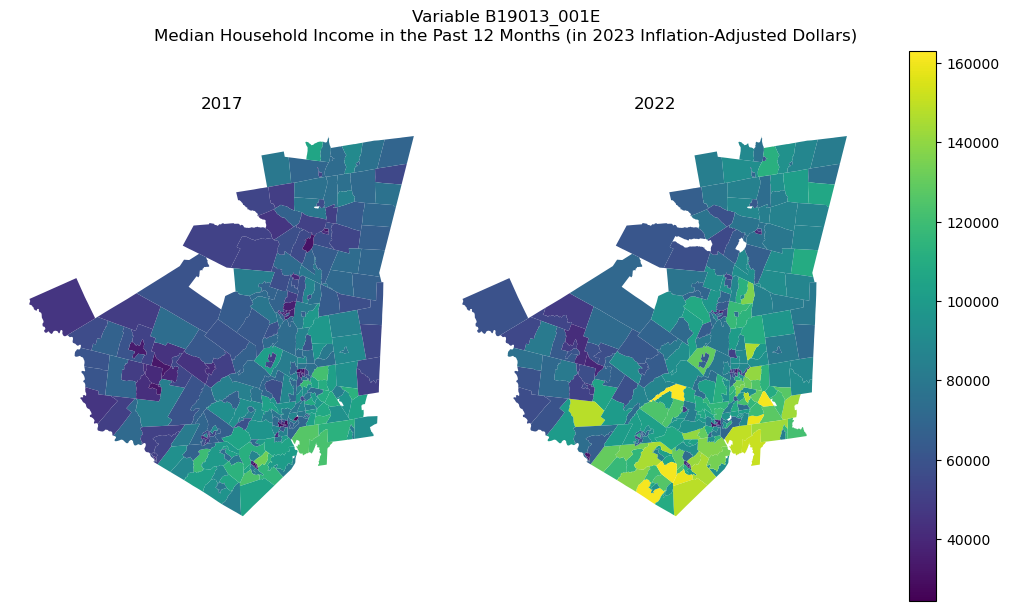

In [91]:
vmin = min([gdf_tracts_core_2017['B19013_001E'].min(),gdf_tracts_core_2022['B19013_001E'].min()])
vmax = max([gdf_tracts_core_2017['B19013_001E'].max(),gdf_tracts_core_2022['B19013_001E'].max()])

fig, axs = plt.subplots(1,2, constrained_layout=True, figsize=(10,6))
gdf_tracts_core_2017.plot(column='B19013_001E', ax=axs[0], vmin=vmin, vmax=vmax, cmap='viridis')
gdf_tracts_core_2022.plot(column='B19013_001E', ax=axs[1], vmin=vmin, vmax=vmax, cmap='viridis')
for ax in axs:
    ax.axis("off")

axs[0].set_title("2017")
axs[1].set_title("2022")

cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

fig.colorbar(cbar, ax=axs)
fig.suptitle(f"Variable B19013_001E\n{acs5vars.query("name == 'B19013'")["description"].values[0]}");

In [115]:
acs5_fields[2:]

['B25038_001E',
 'B25003_001E',
 'B25071_001E',
 'B25057_001E',
 'B25059_001E',
 'B25058_001E',
 'B19013_001E']

In [131]:
gdf_tracts_core_2017.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME_x,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,COUNTYFIPS,NAME_y,B25039_001E,B25038_001E,B25003_001E,B25071_001E,B25057_001E,B25059_001E,B25058_001E,B19013_001E
0,36,105,950800,36105950800,9508,Census Tract 9508,G5020,S,83049493,1537088,...,36105,"Census Tract 9508, Sullivan County, New York",2003.0,1549,1549,48.0,600.0,698.0,640.0,44795.0
1,36,105,951000,36105951000,9510,Census Tract 9510,G5020,S,30767147,853713,...,36105,"Census Tract 9510, Sullivan County, New York",2005.0,1095,1095,29.5,544.0,950.0,630.0,39161.0
2,36,105,951300,36105951300,9513,Census Tract 9513,G5020,S,171850878,6440202,...,36105,"Census Tract 9513, Sullivan County, New York",2003.0,1597,1597,31.1,584.0,1028.0,806.0,59759.0


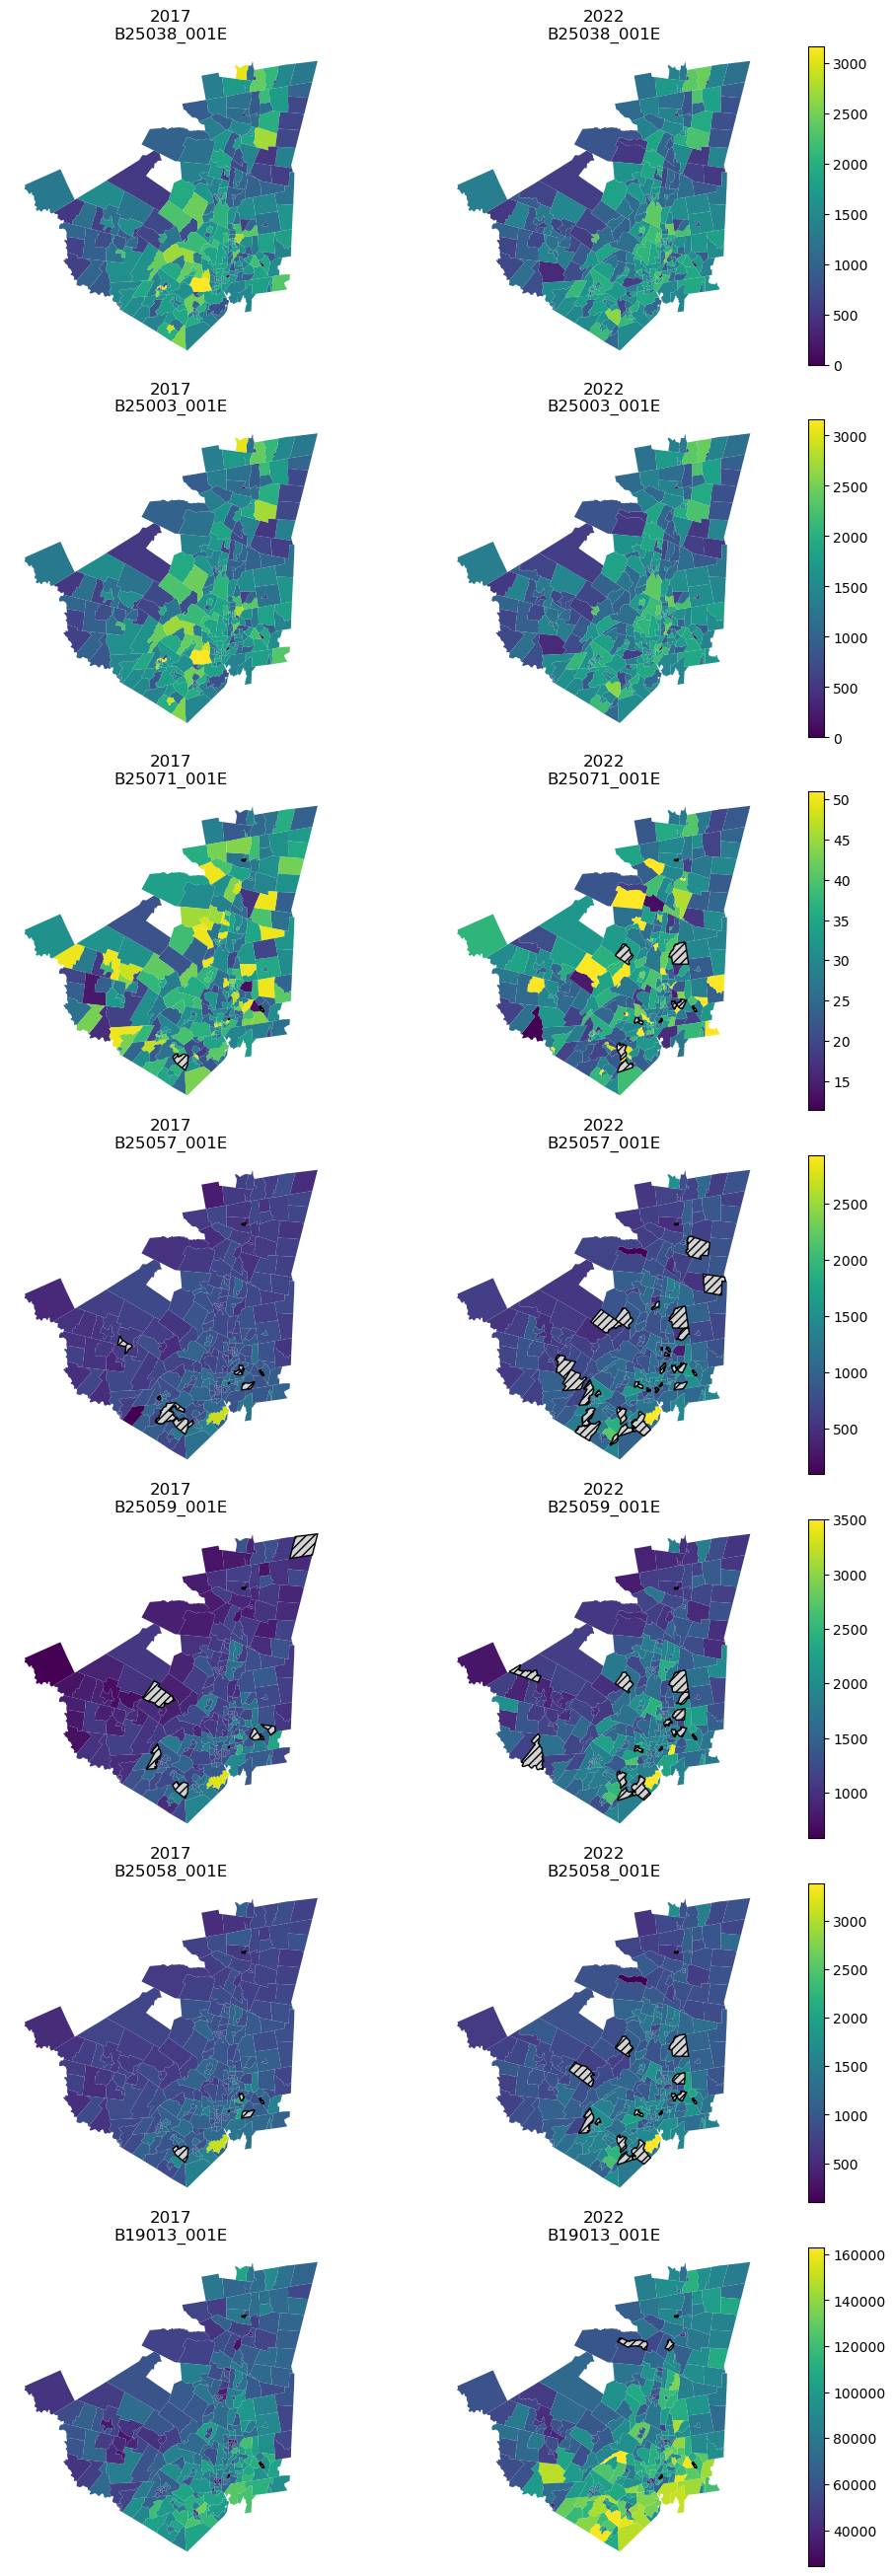

In [123]:
fig, axs = plt.subplots(len(acs5_fields[2:]),2, constrained_layout=True, figsize=(10,26))

for i, acsvar in enumerate(acs5_fields[2:]):
    min2017 = gdf_tracts_core_2017[acsvar].dropna().min().item()
    min2022 = gdf_tracts_core_2022[acsvar].dropna().min().item()
    max2017 = gdf_tracts_core_2017[acsvar].dropna().max().item()
    max2022= gdf_tracts_core_2022[acsvar].dropna().max().item()
    vmin = min(min2017,min2022)
    vmax = max(max2017,max2022)

    
    gdf_tracts_core_2017.plot(column=acsvar, ax=axs[i,0], vmin=vmin, vmax=vmax, cmap='viridis', missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "////",
        "label": "Missing values",
    })
    gdf_tracts_core_2022.plot(column=acsvar, ax=axs[i,1], vmin=vmin, vmax=vmax, cmap='viridis', missing_kwds={
        "color": "lightgrey",
        "edgecolor": "black",
        "hatch": "////",
        "label": "Missing values",
    })
    for ax in axs.flat:
        ax.axis("off")

    axs[i,0].set_title(f"2017\n{acsvar}")
    axs[i,1].set_title(f"2022\n{acsvar}")

    cbar = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='viridis')

    fig.colorbar(cbar, ax=axs[i]);